In [1]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [2]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [3]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [4]:
# optimizer
ga = GA(
    dict(
        m = 75,
        x_rate = 0.5,
        m_rate = 0.6,
        weight_constraint = [-3.,3.],
        radioactive_rating = 0.5,
        grow_factor = 0.5,
        scale_hyperparameter = False))

In [5]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = ga, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy', 'precision', 'recall', 'f1'])

building layer 1 with 5
24
building layer 2 with 4
15


In [6]:
# data loading
DATA = os.path.join('c:\\Users\\tcumi\\github_repo\\neural-network\\', 'dataset')
GROUP = 1
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 500
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [7]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [8]:
# learning phase
breakpoint = 100
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)

C:\Users\tcumi\github_repo\neural-network\python\ga.py:189: RuntimeWarning: overflow encountered in add
  self.population.sort(key=lambda p: p.fitness + np.random.uniform(-shift, shift, 1), reverse = self.aim)
C:\Users\tcumi\github_repo\neural-network\python\activations.py:14: RuntimeWarning: overflow encountered in exp
  y = 1 / (1 + np.exp(-Xi))


Checkpoint 100, Accuracy: 0.845679012345679, Loss: 0.5990802623607494
Checkpoint 200, Accuracy: 0.8765432098765432, Loss: 0.578438193709762
Checkpoint 300, Accuracy: 0.8765432098765432, Loss: 0.5786244780929001
Checkpoint 400, Accuracy: 0.8703703703703703, Loss: 0.5774988245081019
Checkpoint 500, Accuracy: 0.8641975308641975, Loss: 0.5768081876966689


In [9]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for y in y_list:
        ax.plot(x, y)
    if x_label is not None and y_label is not None:
        title = '{} VS {}'.format(x_label, y_label)
        ax.set(xlabel=x_label, ylabel=y_label, title=title)
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

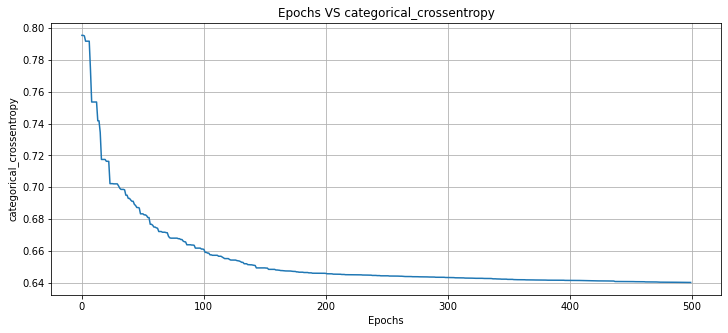

In [10]:
draw_plot(x = [i for i in range(len(history))], y_list = [history], x_label = 'Epochs', \
    y_label = model.loss_fn)

In [11]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[1. 0. 0.] <-> [[0.9069087 ]
 [0.06059768]
 [0.0324936 ]]
[1. 0. 0.] <-> [[0.738712  ]
 [0.16273336]
 [0.09855459]]
[0. 0. 1.] <-> [[0.00560067]
 [0.4478631 ]
 [0.5465362 ]]
[1. 0. 0.] <-> [[0.6208301 ]
 [0.21012045]
 [0.16904943]]
[1. 0. 0.] <-> [[0.6316894 ]
 [0.20084272]
 [0.16746789]]
[1. 0. 0.] <-> [[0.55918396]
 [0.24820787]
 [0.1926082 ]]
[1. 0. 0.] <-> [[0.9040071 ]
 [0.06241845]
 [0.03357455]]
[0. 1. 0.] <-> [[0.00578041]
 [0.44856247]
 [0.5456571 ]]
[1. 0. 0.] <-> [[0.47882926]
 [0.2980835 ]
 [0.22308724]]
[1. 0. 0.] <-> [[0.9160813 ]
 [0.05479141]
 [0.02912723]]
[1. 0. 0.] <-> [[0.91649055]
 [0.05453223]
 [0.02897717]]
[1. 0. 0.] <-> [[0.9159525 ]
 [0.05487306]
 [0.02917444]]
[1. 0. 0.] <-> [[0.9149621 ]
 [0.05550103]
 [0.02953684]]
[1. 0. 0.] <-> [[0.91361535]
 [0.05635555]
 [0.03002906]]
[1. 0. 0.] <-> [[0.9127966 ]
 [0.05687514]
 [0.0303283 ]]
[0. 1. 0.] <-> [[0.4212795 ]
 [0.33505926]
 [0.24366122]]
[1. 0. 0.] <-> [[0.9161531 ]
 [0.05474596]
 [0.02910095]]
[1. 0. 0.] <->

In [12]:
# Testing Performance

In [13]:
for checkpoint in checkpoints:
    print(checkpoint, '\n\n')

{'accuracy': 0.845679012345679, 'mean_square_error': 2.8538877559509017, 'categorical_crossentropy': 0.5990802623607494, 'precision': 0.7685185185185185, 'recall': 0.7685185185185185, 'f1': 0.7685185185185186, 'essential_metrics': {0: {'tp_hit': 77, 'fp_hit': 14, 'tn_hit': 14, 'fn_hit': 3}, 1: {'tp_hit': 4, 'fp_hit': 7, 'tn_hit': 86, 'fn_hit': 11}, 2: {'tp_hit': 2, 'fp_hit': 4, 'tn_hit': 91, 'fn_hit': 11}}, 'checkpoint': 100} 


{'accuracy': 0.8765432098765432, 'mean_square_error': 2.89964805282268, 'categorical_crossentropy': 0.578438193709762, 'precision': 0.8148148148148148, 'recall': 0.8148148148148148, 'f1': 0.8148148148148148, 'essential_metrics': {0: {'tp_hit': 79, 'fp_hit': 14, 'tn_hit': 14, 'fn_hit': 1}, 1: {'tp_hit': 0, 'fp_hit': 0, 'tn_hit': 93, 'fn_hit': 15}, 2: {'tp_hit': 9, 'fp_hit': 6, 'tn_hit': 89, 'fn_hit': 4}}, 'checkpoint': 200} 


{'accuracy': 0.8765432098765432, 'mean_square_error': 2.9044922605839707, 'categorical_crossentropy': 0.5786244780929001, 'precision': 0.

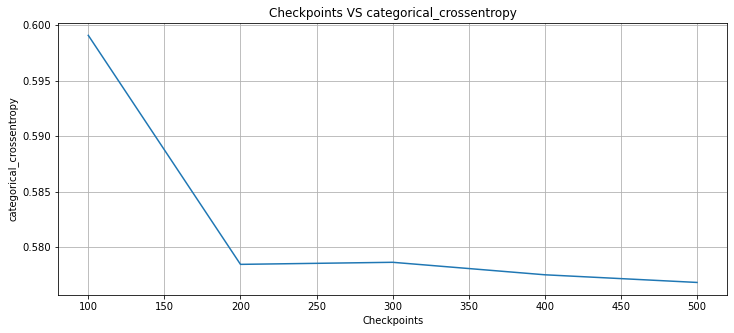

In [14]:
cat_cross = [ ckp[model.loss_fn] for ckp in checkpoints ]
draw_plot(x = [(i+1)*breakpoint for i in range(len(checkpoints))], y_list = [cat_cross], x_label = 'Checkpoints', \
    y_label = model.loss_fn)

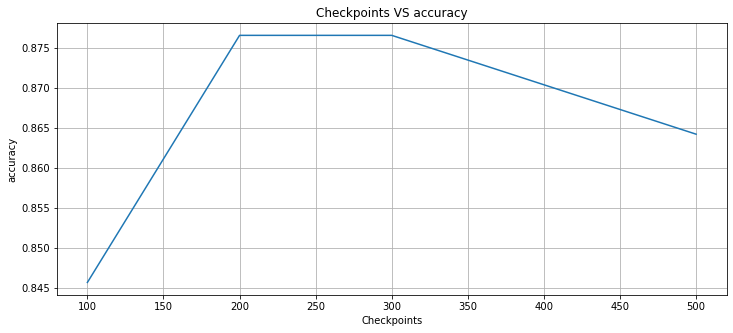

In [15]:
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [(i+1)*breakpoint for i in range(len(checkpoints))], y_list = [acc], x_label = 'Checkpoints', \
    y_label = 'accuracy')

In [16]:
print(model)

Layer 1
Neuron 0: weights:
[[3.      ]
 [3.      ]
 [3.      ]
 [3.      ]
 [2.035655]]
 bias: [2.7030504]

Neuron 1: weights:
[[ 2.3789263 ]
 [ 1.2660885 ]
 [-0.76966566]
 [-2.863148  ]
 [-1.5037404 ]]
 bias: [3.]

Neuron 2: weights:
[[-0.3770267]
 [-2.083519 ]
 [ 1.9003686]
 [-2.7580974]
 [-2.6649718]]
 bias: [2.5352595]

Neuron 3: weights:
[[ 2.41528   ]
 [ 0.29238006]
 [ 1.0625333 ]
 [ 1.0588043 ]
 [-2.949414  ]]
 bias: [-3.]

$
Layer 2
Neuron 0: weights:
[[-0.77861613]
 [ 1.5459055 ]
 [-3.        ]
 [-3.        ]]
 bias: [0.64878404]

Neuron 1: weights:
[[ 1.8368137]
 [-1.0622799]
 [-0.6427913]
 [ 1.5962098]]
 bias: [-1.9357162]

Neuron 2: weights:
[[ 2.0972579 ]
 [-1.4832027 ]
 [-0.78091234]
 [ 1.6378144 ]]
 bias: [-2.010216]

$

